In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Neural Networks
import tensorflow
import keras

# AWS
import boto3

# Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Downloading Data from a Bucket

In [2]:
!ls ~/.aws

credentials


In [3]:
s3 = boto3.resource("s3")

In [22]:
# Looking at all buckets
for bucket in s3.buckets.all():
    print(bucket)

bucket = s3.Bucket("firearm-image-classification")

s3.Bucket(name='firearm-image-classification')
s3.Bucket(name='jefferson-demo-0106')


In [2]:
# prints the contents of bucket
for s3_file in bucket.objects.all():
    print(s3_file.key)

In [27]:
# Downloading all Objects in the bucket to current directory
!aws s3 sync s3://firearm-image-classification .

In [2]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "SpecifiedData",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=1277,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 1277 images belonging to 2 classes.


In [4]:
# Data Classes
image_gen.class_indices  # From directory (the way it was labeled)

{'Assault Rifle': 0, 'Handgun': 1}

In [5]:
image_gen.image_shape

(300, 300, 3)

## Images and Lables

In [6]:
# split images and labels
images, labels = next(image_gen)
images.shape, labels.shape

((1277, 300, 300, 3), (1277, 2))

## Showing Images

Classes:{'Assault Rifle': 0, 'Handgun': 1}
[1. 0.]


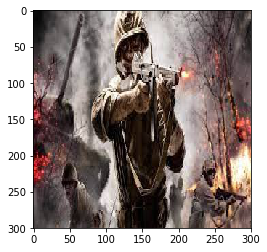

In [7]:
def show_image(n):
    
    print(f"Classes:{image_gen.class_indices}")
    plt.imshow(images[n])
    print(labels[n])
    
show_image(80)

## Train and Test Split

In [8]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.2, random_state=41)
X_model.shape, X_test.shape, y_model.shape, y_test.shape

((1021, 300, 300, 3), (256, 300, 300, 3), (1021, 2), (256, 2))

## Validation Set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=41)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((816, 300, 300, 3), (205, 300, 300, 3), (816, 2), (205, 2))

In [10]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dense(2, activation='softmax'))

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [11]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [12]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [13]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [14]:
print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                92160064  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 92,161,986
Trainable params: 92,161,986
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# This was ran 2 times for a total of 60 epochs
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=30,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 1097 samples, validate on 275 samples
Epoch 1/30
1097/1097 [==============================] - 74s 68ms/step - loss: 0.4412 - acc: 0.8095 - val_loss: 0.5482 - val_acc: 0.7273
Epoch 2/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.4329 - acc: 0.8186 - val_loss: 0.5817 - val_acc: 0.6873
Epoch 3/30
1097/1097 [==============================] - 74s 67ms/step - loss: 0.4127 - acc: 0.8496 - val_loss: 0.5720 - val_acc: 0.7273
Epoch 4/30
1097/1097 [==============================] - 74s 67ms/step - loss: 0.4218 - acc: 0.8414 - val_loss: 0.5566 - val_acc: 0.7455
Epoch 5/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.3864 - acc: 0.8569 - val_loss: 0.5374 - val_acc: 0.7382
Epoch 6/30
1097/1097 [==============================] - 74s 68ms/step - loss: 0.3549 - acc: 0.8797 - val_loss: 0.7982 - val_acc: 0.5455
Epoch 7/30
1097/1097 [==============================] - 75s 68ms/step - loss: 0.3732 - acc: 0.8687 - val_loss: 0.5986 - val_acc: 0.6945
E

In [28]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

343/343 [==============================] - 7s 20ms/step
[0.09800265907371924, 0.983591616153717] [0.523403563061539, 0.7580174803733826]


## Hyperparameter Tuning

In [38]:
# Convenlutional Neural Network Model
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=(300, 300,  3),
                      padding='SAME'))
cnn.add(keras.layers.MaxPooling2D((2, 2)))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(32, activation='relu'))
cnn.add(keras.layers.Dense(2, activation='softmax'))

# Producing Neural Network
cnn.compile(loss='binary_crossentropy',  # Loss function
            optimizer="sgd",  # Gradient Descent
            metrics=['acc'])  # Accuracy score

In [39]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, patience=20,
    verbose=0, mode='auto', min_lr=0)

In [40]:
# If there are problems with input data then it will stop it
nan_problem = keras.callbacks.TerminateOnNaN()

In [41]:
# Stops Epochs when modeling stops to improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=20,
    verbose=0, mode='auto')

In [42]:
print(cnn.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                46080032  
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 46,081,890
Trainable params: 46,081,890
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# This was ran 2 times for a total of 60 epochs
cnn1 = cnn.fit(X_train,
               y_train,
               validation_data=(X_val, y_val),
               epochs=30,
               batch_size=100,
               callbacks=[early_stop, nan_problem, reduce_lr])

Train on 816 samples, validate on 205 samples
Epoch 1/30
816/816 [==============================] - 52s 63ms/step - loss: 2.0641 - acc: 0.5907 - val_loss: 0.6557 - val_acc: 0.6732
Epoch 2/30
816/816 [==============================] - 50s 61ms/step - loss: 0.6660 - acc: 0.6458 - val_loss: 0.6444 - val_acc: 0.6732
Epoch 3/30
816/816 [==============================] - 50s 61ms/step - loss: 0.6546 - acc: 0.6458 - val_loss: 0.6349 - val_acc: 0.6732
Epoch 4/30
816/816 [==============================] - 51s 62ms/step - loss: 0.6447 - acc: 0.6458 - val_loss: 0.6493 - val_acc: 0.6927
Epoch 5/30
816/816 [==============================] - 50s 61ms/step - loss: 0.6346 - acc: 0.6593 - val_loss: 0.6256 - val_acc: 0.6732
Epoch 6/30
816/816 [==============================] - 50s 61ms/step - loss: 0.6225 - acc: 0.6471 - val_loss: 0.6183 - val_acc: 0.6732
Epoch 7/30
816/816 [==============================] - 50s 61ms/step - loss: 0.6086 - acc: 0.6532 - val_loss: 0.6647 - val_acc: 0.5756
Epoch 8/30
816/8

KeyboardInterrupt: 

In [30]:
results_train = cnn.evaluate(X_train, y_train)
results_test = cnn.evaluate(X_test, y_test)
print(results_train, results_test)

256/256 [==============================] - 7s 28ms/step
[0.7528840291733835, 0.46691176295280457] [0.8276172950863838, 0.38671875]
